In [1]:
import tensorflow as tf
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
np.random.seed = SEED

TRAIN_PATH = 'D:\\Shiny_icarus\\train\\'
TEST_PATH = 'D:\\Shiny_icarus\\test\\'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3 #三原色

In [3]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]    # next : 返回下一個項目
test_ids = next(os.walk(TEST_PATH))[1]    # walk : 通過在目錄中游走输出在目錄中的文件名
# define placeholders (also used to replace NaN in images to resize by 0)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8) # zeros : 全零矩陣
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

In [5]:
# Resize images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): # enumerate : 組合为一個索引序列
    
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(
        img, (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    # fill empty X_train with values from img 
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(
            resize(
                mask_, 
                (IMG_HEIGHT, IMG_WIDTH), 
                mode = 'constant', 
                preserve_range = True
            ), 
            axis = -1
        )
        # mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

100%|██████████| 10/10 [00:00<00:00, 41.00it/s]


In [7]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)

sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(
        img, 
        (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    X_test[n] = img

100%|██████████| 6/6 [00:00<00:00, 29.39it/s]


In [6]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # normalization

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [8]:
# Callbacks
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]

In [15]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.5, 
    batch_size = 16, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25
1/1 [==============================] - 1s 547ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/25
1/1 [==============================] - 1s 515ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/25
1/1 [==============================] - 1s 599ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/25
1/1 [==============================] - 1s 693ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/25
1/1 [==============================] - 1s 706ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/25
1/1 [==============================] - 1s 809ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [16]:
# Predictions
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 111ms/step


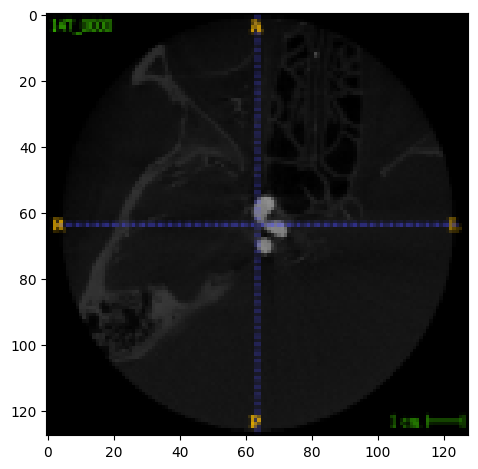

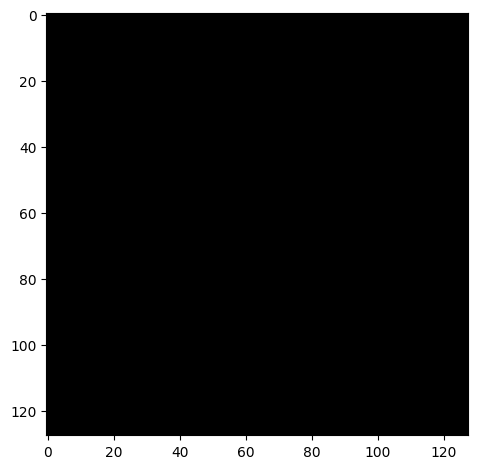

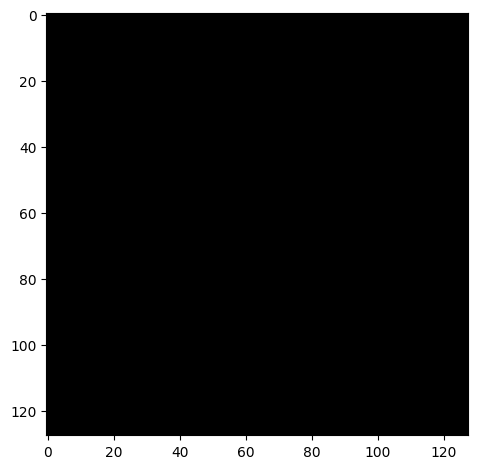

In [17]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()